# We visualize VibVoice+
1. We visualize the frequency distribution of the VibVoice+ datasets.
2. We visualize the correlation between vibration and speech under different conditions.

In [2]:
import numpy as np
import json
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats  as stats
import scipy.signal as signal


100%|██████████| 2864/2864 [00:05<00:00, 534.71it/s]


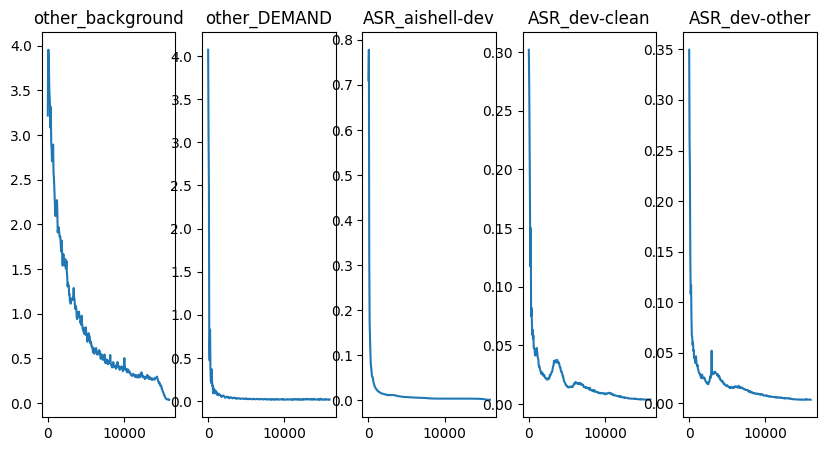

In [3]:
datasets = ['json/other_background.json', 'json/other_DEMAND.json', 'json/ASR_aishell-dev.json', 'json/ASR_dev-clean.json', 'json/ASR_dev-other.json']
fftfreq = np.arange(0, 16000, 16000/320)
fig, axs = plt.subplots(1, len(datasets), figsize=(10, 5))
for i, data in enumerate(datasets):
    files = json.load(open(data, 'r'))
    fft = np.zeros((320, ))
    for tuple in tqdm(files):
        file, _ = tuple 
        noise_new_added, sr = librosa.load(file, sr=None, mono=True)
        fft += np.abs(np.fft.fft(noise_new_added, n=640)[:320])
    fft /= len(files)
    axs[i].plot(fftfreq, fft)
    axs[i].set_title(data[5:-5])
# plt.savefig('freq_distribution.png')
plt.show()

100%|██████████| 526/526 [00:01<00:00, 278.98it/s]


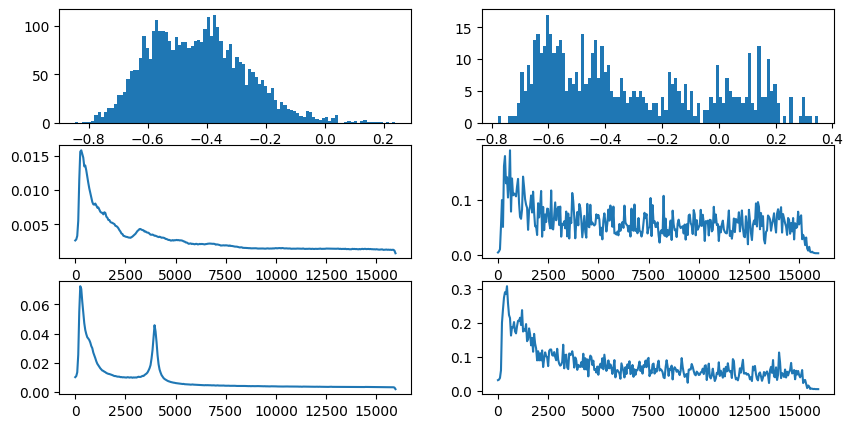

In [48]:

b, a = signal.butter(4, 100, 'highpass', fs=16000)
datasets = [
            # 'json/EMSB.json',
            'json/ABCS_dev.json', 
            'json/V2S.json',
            ]
fig, axs = plt.subplots(3, len(datasets), figsize=(10, 5))
fftfreq = np.arange(0, 16000, 16000/320)

for i, data in enumerate(datasets):
    correlation = []
    if data == 'json/EMSB.json':
        # only for EMSB
        files = json.load(open(data, 'r'))['left']
    else:
        files_all = json.load(open(data, 'r'))
        files = []
        for key in files_all.keys():
            files += files_all[key]
    fft = np.zeros((2, 320, ))
    for file in tqdm(files):
        recording, sr = librosa.load(file[0], sr=None, mono=False)
        recording = signal.filtfilt(b, a, recording)
        pearsonr = stats.pearsonr(recording[0], recording[1])[0]
        correlation.append(pearsonr)
        fft += np.abs(np.fft.fft(recording, n=640, axis=-1)[:, :320])
    fft /= len(files)
    axs[0, i].hist(correlation, bins=100)
    axs[1, i].plot(fftfreq, fft[0])
    axs[2, i].plot(fftfreq, fft[1])
plt.show()

  0%|          | 0/526 [00:00<?, ?it/s]

(251,) (321, 251)


<Figure size 3000x2000 with 0 Axes>

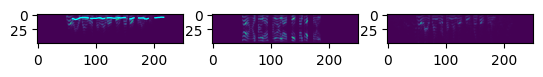

  0%|          | 0/526 [00:00<?, ?it/s]


In [33]:

'''
We reproduce VoiceListener, IMWUT'23 here
'''
def Aliasing_Correction(stft, pitch):
    def AF(f):
        return abs(f - int(f/50 + 0.5) * 50)
    new_stft = np.zeros_like(stft)
    for t in range(pitch.shape[-1]):
        if np.isnan(pitch[t]):
            continue
        else:
            pitch_t = int(pitch[t] // 50) + 1
        for f in range(50):
            if f > (25):
                if f % pitch_t == 0:
                    new_stft[f, t] = stft[AF(f), t]
            else:
                if f % pitch_t == 0:
                    new_stft[f, t] = stft[f, t]
    return new_stft
b, a = signal.butter(4, 100, 'highpass', fs=16000)
datasets = [
            'json/V2S.json',
            ]
for i, data in enumerate(datasets):
    correlation = []
    if data == 'json/EMSB.json':
        files = json.load(open(data, 'r'))['left']
    else:
        files_all = json.load(open(data, 'r'))
        files = []
        for key in files_all.keys():
            files += files_all[key]
    for file in tqdm(files):
        recording, sr = librosa.load(file[0], sr=None, mono=False)
        recording = signal.filtfilt(b, a, recording)
        stft_bc = np.abs(librosa.stft(y=recording[0], n_fft=640, hop_length=320, win_length=640))
        stft_ac = np.abs(librosa.stft(y=recording[1], n_fft=640, hop_length=320, win_length=640))
        f0, voiced_flag, voiced_probs = librosa.pyin(recording[0], win_length=640, hop_length=320, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        times = librosa.times_like(f0)
        pitch = f0 / (sr / 640)
        new_stft = Aliasing_Correction(stft_bc, pitch)
        fig = plt.figure(figsize=(30, 20))
        fig, axs = plt.subplots(1, 3)

        axs[0].imshow(stft_bc[:50])
        axs[0].plot(times*50, pitch, label='f0', color='cyan', linewidth=1)
        axs[1].imshow(new_stft[:50])
        axs[2].imshow(stft_ac[:50])
        plt.show()
        break